<a href="https://colab.research.google.com/github/Karthik2486/Butterfly_Recognition_Model/blob/main/Model_1/Butterfly_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Butterfly Recognition
Train, Test. Validation data set for 50 butterfly species. All images are 224 X 224 X 3 in jpg format . Train set consists of 4955 images partitioned into 50 sub directories one for each species. Test set consists of 250 images partitioned into 50 sub directories with 5 test images per species. Valid set consists of 250 images partitioned into 50 sub directories with 5 validation images per species. 1 CSV file is included with 3 columns filepaths, labels and dataset. filepaths is the relative path to an image. labels is the string name of the species associate with the image file. dataset species the directory (train, test, valid) that contains the image file.

In [1]:
# Install kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karthikb700","key":"8d2a826dbe4909ac7f8a73e91c44dcd6"}'}

In [3]:
# Create a kaggle folder
! mkdir ~/.kaggle

In [4]:
# copy the kaggle.json to the folder created
! cp kaggle.json ~/.kaggle/

In [5]:
# Permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# To list all the datasets in kaggle
! kaggle datasets list

ref                                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/piterfm/2022-ukraine-russian-war                                 2022 Ukraine Russia War                              1KB  2022-03-29 09:48:26           3278        217  1.0              
datasets/prasertk/healthy-lifestyle-cities-report-2021                    Healthy Lifestyle Cities Report 2021                 2KB  2022-03-03 00:26:02           3283         99  1.0              
datasets/kamilpytlak/personal-key-indicators-of-heart-disease             Personal Key Indicators of Heart Disease             3MB  2022-02-16 10:18:03           5574        118  1.0              
datasets/vivek4

In [7]:
! kaggle datasets download -d gpiosenka/butterfly-images40-species

 99% 361M/365M [00:02<00:00, 137MB/s]
100% 365M/365M [00:02<00:00, 163MB/s]


In [8]:
# To view which GPU are we running 
! nvidia-smi

Tue Mar 29 16:30:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
# Downloading helper_functions.py
! wget https://raw.githubusercontent.com/Karthik2486/Butterfly_Recognition_Model/main/helper_functions.py

--2022-03-29 17:05:33--  https://raw.githubusercontent.com/Karthik2486/Butterfly_Recognition_Model/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10139 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.90K  --.-KB/s    in 0s      

2022-03-29 17:05:33 (77.8 MB/s) - ‘helper_functions.py’ saved [10139/10139]



# Importing Dependancies

In [16]:
# Importing dependancies
import os
import random
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from helper_functions import unzip_data, walk_through_dir, plot_loss_curves, make_confusion_matrix, compare_historys

In [17]:
# Unzipping our data
unzip_data("/content/butterfly-images40-species.zip")

In [18]:
# deleting the zip file
!rm butterfly-images40-species.zip

In [20]:
# A look through all the directories in the dataset
walk_through_dir("/content/butterflies")

In [23]:
labels = os.listdir("/content/train")
len(labels)


75

#Getting Data ready

In [27]:
# creating a list of all the training file paths
train_file_paths = []
for elem in labels:
  dir_path = "/content/train/" + elem
  paths = os.listdir(dir_path)
  for path in paths:
    path = dir_path + "/" + path
    train_file_paths.append(path)

In [28]:
len(train_file_paths)

9285

In [29]:
# randomly checking a part of the list
train_file_paths[100:110]

['/content/train/MANGROVE SKIPPER/04.jpg',
 '/content/train/MANGROVE SKIPPER/50.jpg',
 '/content/train/MANGROVE SKIPPER/16.jpg',
 '/content/train/MANGROVE SKIPPER/25.jpg',
 '/content/train/MANGROVE SKIPPER/112.jpg',
 '/content/train/MANGROVE SKIPPER/43.jpg',
 '/content/train/MANGROVE SKIPPER/124.jpg',
 '/content/train/MANGROVE SKIPPER/86.jpg',
 '/content/train/MANGROVE SKIPPER/88.jpg',
 '/content/train/MANGROVE SKIPPER/22.jpg']

In [30]:
# To read and preprocess the image
def load_and_preprocess(filepath):
  """
  Takes a file path and preprocess images into 224 x 3 
  """
  img_file = tf.io.read_file(filepath)
  img = tf.image.decode_image(img_file)
  img = tf.image.resize(img, (224, 224))
  
  return img

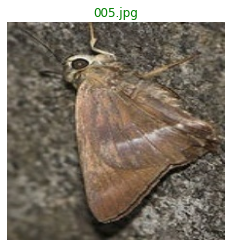

In [32]:
# Visualizing random image
random_file = random.choice(train_file_paths)
img = load_and_preprocess(random_file)
plt.axis(False)
plt.title(random_file.split("/")[4], color="green")
plt.imshow(img / 255.);

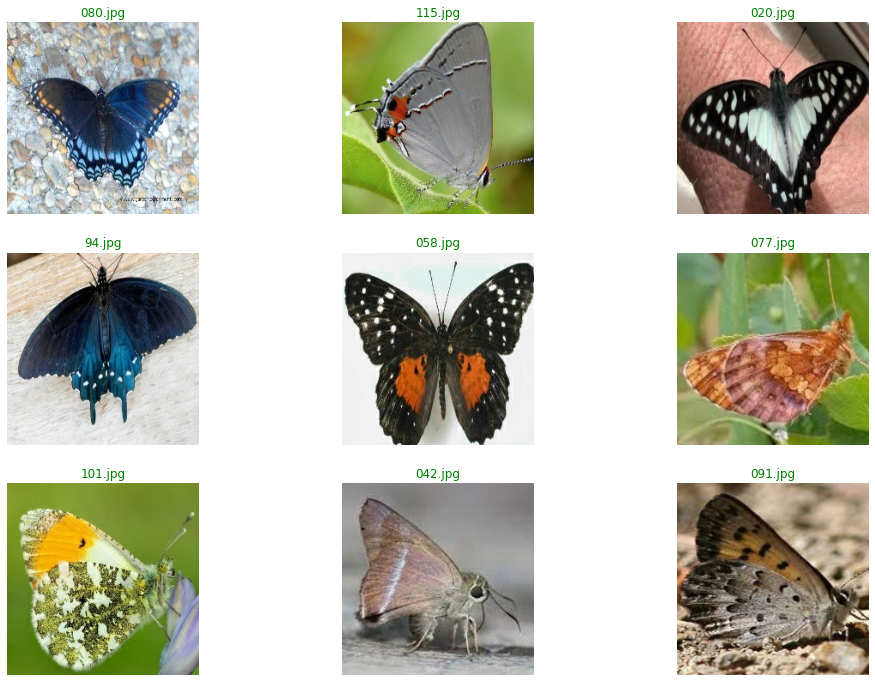

In [33]:
# Visualizing multiple random images
plt.figure(figsize=(17, 12))
for i in range(9):
  # Random selecting an image from the train dataset
  random_file = random.choice(train_file_paths)
  img = load_and_preprocess(random_file)

  # Plotting the random images
  plt.subplot(3, 3, i+1)
  plt.title(random_file.split("/")[4], color="green")
  plt.axis(False)
  plt.imshow(img / 255.)

#Data Agumentation Layer

In [34]:
# Creating data augmentation layer
data_augmentation = tf.keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name="data_augmentation_layer")

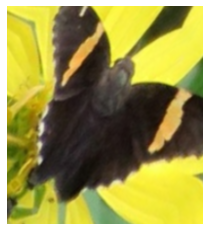

In [35]:
# Visualizing the augmented image
random_file = random.choice(train_file_paths)
img = load_and_preprocess(random_file)

aug_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.axis(False)
plt.imshow(aug_img[0] / 255.)

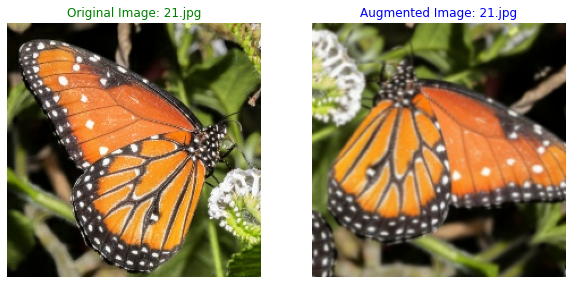

In [36]:
# Visualizing the augmentated image with the original image
random_file = random.choice(train_file_paths)
img = load_and_preprocess(random_file)
aug_img = data_augmentation(tf.expand_dims(img, axis=0))
aug_img = tf.image.resize(aug_img[0], (224, 224))
label = random_file.split("/")[4]

plt.figure(figsize=(10, 7))
# Plot for original image
plt.subplot(1, 2, 1)
plt.title(f"Original Image: {label}", color = "green")
plt.axis(False)
plt.imshow(img / 255.)

# Plot for augmented image
plt.subplot(1, 2, 2)
plt.title(f"Augmented Image: {label}", color = "blue")
plt.axis(False)
plt.imshow(aug_img / 255.);

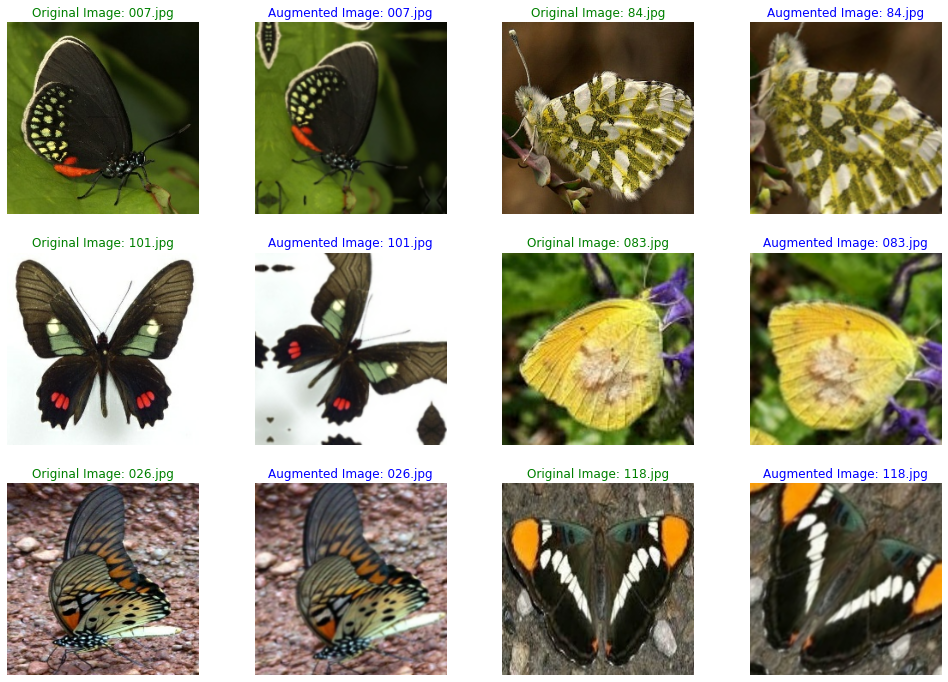

In [37]:
# Visualizing multiple augmentated images with original images
plt.figure(figsize=(17, 12))
for i in range(1, 12, 2):
  # generating random file path & aug img
  random_file = random.choice(train_file_paths)
  img = load_and_preprocess(random_file)
  aug_img = data_augmentation(tf.expand_dims(img, axis=0))
  aug_img = tf.image.resize(aug_img[0], (224, 224))
  label = random_file.split("/")[4]
  
  # plotting the original image
  plt.subplot(3, 4, i)
  plt.title(f"Original Image: {label}", color = "green")
  plt.axis(False)
  plt.imshow(img / 255.)
  
  # plotting the augmented image
  plt.subplot(3, 4, i+1)
  plt.title(f"Augmented Image: {label}", color = "blue")
  plt.axis(False)
  plt.imshow(aug_img / 255.);

#Data Generators

In [38]:
train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

In [40]:
train_data = train_data_gen.flow_from_directory("/content/train/",
                                                target_size=(224, 224),
                                                seed=42)

valid_data = valid_data_gen.flow_from_directory("/content/valid/",
                                                target_size=(224, 224),
                                                shuffle=False)

test_data = test_data_gen.flow_from_directory("/content/test/",
                                                target_size=(224, 224),
                                                shuffle=False)

Found 9285 images belonging to 75 classes.
Found 375 images belonging to 75 classes.
Found 375 images belonging to 75 classes.


In [41]:
# To get all the class names
class_ = train_data.class_indices
class_names = []
for key in class_.keys():
  class_names.append(key)

In [42]:
class_names



['ADONIS',
 'AFRICAN GIANT SWALLOWTAIL',
 'AMERICAN SNOOT',
 'AN 88',
 'APPOLLO',
 'ATALA',
 'BANDED ORANGE HELICONIAN',
 'BANDED PEACOCK',
 'BECKERS WHITE',
 'BLACK HAIRSTREAK',
 'BLUE MORPHO',
 'BLUE SPOTTED CROW',
 'BROWN SIPROETA',
 'CABBAGE WHITE',
 'CAIRNS BIRDWING',
 'CHECQUERED SKIPPER',
 'CHESTNUT',
 'CLEOPATRA',
 'CLODIUS PARNASSIAN',
 'CLOUDED SULPHUR',
 'COMMON BANDED AWL',
 'COMMON WOOD-NYMPH',
 'COPPER TAIL',
 'CRECENT',
 'CRIMSON PATCH',
 'DANAID EGGFLY',
 'EASTERN COMA',
 'EASTERN DAPPLE WHITE',
 'EASTERN PINE ELFIN',
 'ELBOWED PIERROT',
 'GOLD BANDED',
 'GREAT EGGFLY',
 'GREAT JAY',
 'GREEN CELLED CATTLEHEART',
 'GREY HAIRSTREAK',
 'INDRA SWALLOW',
 'IPHICLUS SISTER',
 'JULIA',
 'LARGE MARBLE',
 'MALACHITE',
 'MANGROVE SKIPPER',
 'MESTRA',
 'METALMARK',
 'MILBERTS TORTOISESHELL',
 'MONARCH',
 'MOURNING CLOAK',
 'ORANGE OAKLEAF',
 'ORANGE TIP',
 'ORCHARD SWALLOW',
 'PAINTED LADY',
 'PAPER KITE',
 'PEACOCK',
 'PINE WHITE',
 'PIPEVINE SWALLOW',
 'POPINJAY',
 'PURPLE HAIRS

#Training Our Models:

#Model_1

In [43]:
# Setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setting input layer 
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer")(x) 
model_1 = tf.keras.Model(inputs, outputs)

# compiling the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/5
291/291 [==============================] - 138s 420ms/step - loss: 1.9086 - accuracy: 0.6516 - val_loss: 1.1593 - val_accuracy: 0.8267
Epoch 2/5
291/291 [==============================] - 90s 309ms/step - loss: 0.7040 - accuracy: 0.8733 - val_loss: 0.7265 - val_accuracy: 0.8800
Epoch 3/5
291/291 [==============================] - 81s 277ms/step - loss: 0.4893 - accuracy: 0.8990 - val_loss: 0.5668 - val_accuracy: 0.9040
Epoch 4/5
291/291 [==============================] - 75s 257ms/step - loss: 0.3881 - accuracy: 0.9188 - val_loss: 0.4966 - val_accuracy: 0.8933
Epoch 5/5
291/291 [==============================] - 70s 239ms/step - loss: 0.3277 - accuracy: 0.9297 - val_loss: 0.4358 - val_accuracy: 0.9040


In [44]:
model_1.evaluate(test_data)

12/12 [==============================] - 2s 179ms/step - loss: 0.4496 - accuracy: 0.9040


[0.4496186375617981, 0.9039999842643738]

#Loss curves for original model

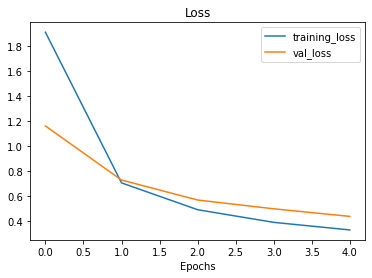

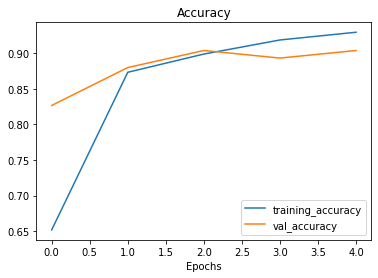

In [45]:
plot_loss_curves(history_1)

#Fine turning the model

In [47]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

# Recompile model with lower learning rate
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

# Fine-tune for 5 more epochs
fine_tune_epochs = 10 

history_1_fine_tune_1 = model_1.fit(train_data,
                                    epochs=fine_tune_epochs,
                                    validation_data=valid_data,
                                    validation_steps= len(valid_data), 
                                    initial_epoch=history_1.epoch[-1])


Epoch 5/10
291/291 [==============================] - 82s 245ms/step - loss: 0.2371 - accuracy: 0.9386 - val_loss: 0.2850 - val_accuracy: 0.9280
Epoch 6/10
291/291 [==============================] - 64s 220ms/step - loss: 0.1967 - accuracy: 0.9464 - val_loss: 0.2669 - val_accuracy: 0.9120
Epoch 7/10
291/291 [==============================] - 65s 224ms/step - loss: 0.1784 - accuracy: 0.9507 - val_loss: 0.2506 - val_accuracy: 0.9253
Epoch 8/10
291/291 [==============================] - 60s 206ms/step - loss: 0.1571 - accuracy: 0.9588 - val_loss: 0.2506 - val_accuracy: 0.9200
Epoch 9/10
291/291 [==============================] - 61s 208ms/step - loss: 0.1486 - accuracy: 0.9567 - val_loss: 0.2386 - val_accuracy: 0.9413
Epoch 10/10
291/291 [==============================] - 58s 198ms/step - loss: 0.1337 - accuracy: 0.9622 - val_loss: 0.2547 - val_accuracy: 0.9173


In [48]:
model_1.evaluate(test_data)

12/12 [==============================] - 2s 163ms/step - loss: 0.3043 - accuracy: 0.9120


[0.3043223023414612, 0.9120000004768372]

# Compared History with original model

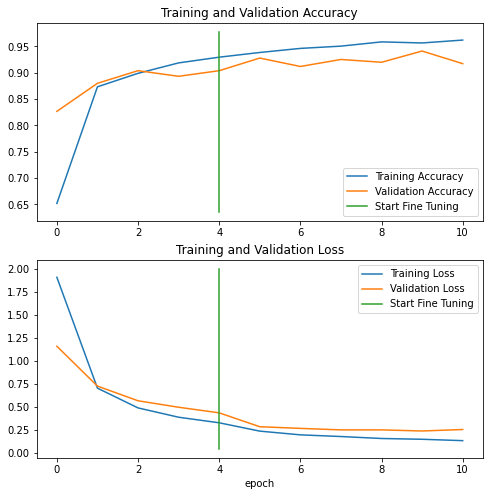

In [49]:
compare_historys(history_1, history_1_fine_tune_1)

#Insights into the best model

In [50]:
label_val = []
for elem in test_data.filepaths:
  for cl in range(50):
    if elem.split("/")[4] == class_names[cl]:
      label_val.append(cl)

In [51]:
label_val[5:10]

[]

In [52]:
# Getting prediction probabilites
pred_prob = model_1.predict(test_data)
pred_prob

array([[9.7842842e-01, 6.4250753e-06, 1.5621930e-06, ..., 2.2678035e-03,
        1.5132574e-06, 1.7773036e-07],
       [5.9581447e-01, 1.2438888e-06, 5.4912844e-06, ..., 6.3148141e-06,
        2.8140776e-06, 3.3993706e-09],
       [9.8722953e-01, 1.0156230e-07, 6.8813350e-08, ..., 6.1044057e-07,
        1.0123029e-04, 1.2628450e-07],
       ...,
       [3.1730755e-07, 5.2511491e-06, 2.0315414e-05, ..., 3.1821291e-06,
        4.3145395e-05, 8.7551391e-01],
       [3.4204270e-10, 5.3786457e-06, 2.3901874e-08, ..., 7.0136815e-07,
        1.6013757e-04, 9.9100351e-01],
       [1.3780944e-09, 2.0751354e-07, 2.0704888e-06, ..., 1.4811560e-08,
        1.8487368e-06, 9.9551338e-01]], dtype=float32)

In [61]:
y_pred = tf.cast(pred_prob.argmax(axis=1), tf.float32)
y_pred[:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ 0.,  0.,  0.,  0., 55.,  1.,  1.,  1.,  1.,  1.,  2.,  2., 43.,
        2.,  2.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  5.,
        5.,  5.,  5.,  5.,  6.,  6., 60.,  6.,  6.,  7.,  7.,  7.,  7.,
        7.,  8., 27.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.],
      dtype=float32)>

In [69]:
y_true = tf.cast(np.array(label_val), tf.float32)
y_true[:50]

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

#Confusion Metrix

In [64]:
make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=10,
                      norm=False)

ValueError: ignored

#Classification report

In [65]:
print(classification_report(y_true, y_pred))

ValueError: ignored